In [2]:
import tensorflow as tf
import numpy as np
import nibabel as nib

# below to make the
import itk                                                                # Jupyter widgets to visualize images in 2D and 3D
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# course
from glob import glob
import os
import SimpleITK as sitk
import time

In [24]:
"""part taken from
https://www.youtube.com/watch?v=Tc9ONZLBHP0
https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case
"""

'part taken from\nhttps://www.youtube.com/watch?v=Tc9ONZLBHP0\nhttps://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case\n'

In [25]:
# Data
# Load Original Image Data

In [3]:
# Define the image path and load the data
image_path = r"E:\Task03_Liver\Task03_Liver\imagesTr\liver_0.nii.gz"
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


In [58]:
# Image Data as Numpy array

In [4]:
# Extract data as numpy ndarray
image_data = image_obj.get_fdata()
type(image_data)


numpy.ndarray

In [5]:
# Get the image shape and print it out
print("image_data.shape ", image_data.shape)
channels = 0
height, width, depth = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")

image_data.shape  (512, 512, 75)
The image object has the following dimensions: height: 512, width:512, depth:75


In [61]:
# Visualize the Data

Plotting Layer 39 Channel 0 of Image


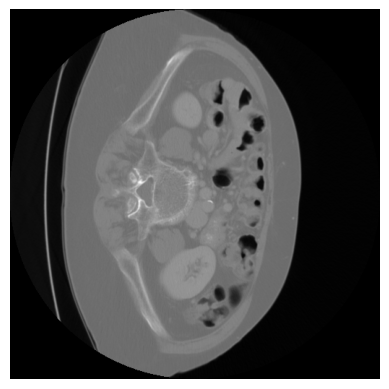

In [6]:
# Select random layer number
maxval = 154
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 0
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image_data[:, :, i], cmap='gray')
plt.axis('off');

In [9]:
# Exploration
# Visualize the single sample

In [7]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.title('Explore Layers of Liver MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=37, description='layer', max=74), Output()), _dom_classes=('widget-inter…

In [65]:
# Explore the data Labels

In [8]:
# Define the data path and load the data
label_path = r"E:\Task03_Liver\Task03_Liver\labelsTr\liver_0.nii.gz"
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

In [14]:
# Labels data as Numpy array

In [9]:
# Extract data labels
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [10]:
# Extract and print out the shape of the labels data
height, width, depth = label_array.shape
print(f"Dimensions of labels data array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(label_array)}')
print("""Corresponding to the following label categories:
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor""")

Dimensions of labels data array height: 512, width: 512, depth: 75
With the unique values: [0. 1. 2.]
Corresponding to the following label categories:
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor


In [18]:
# Visualize the data for specific labels

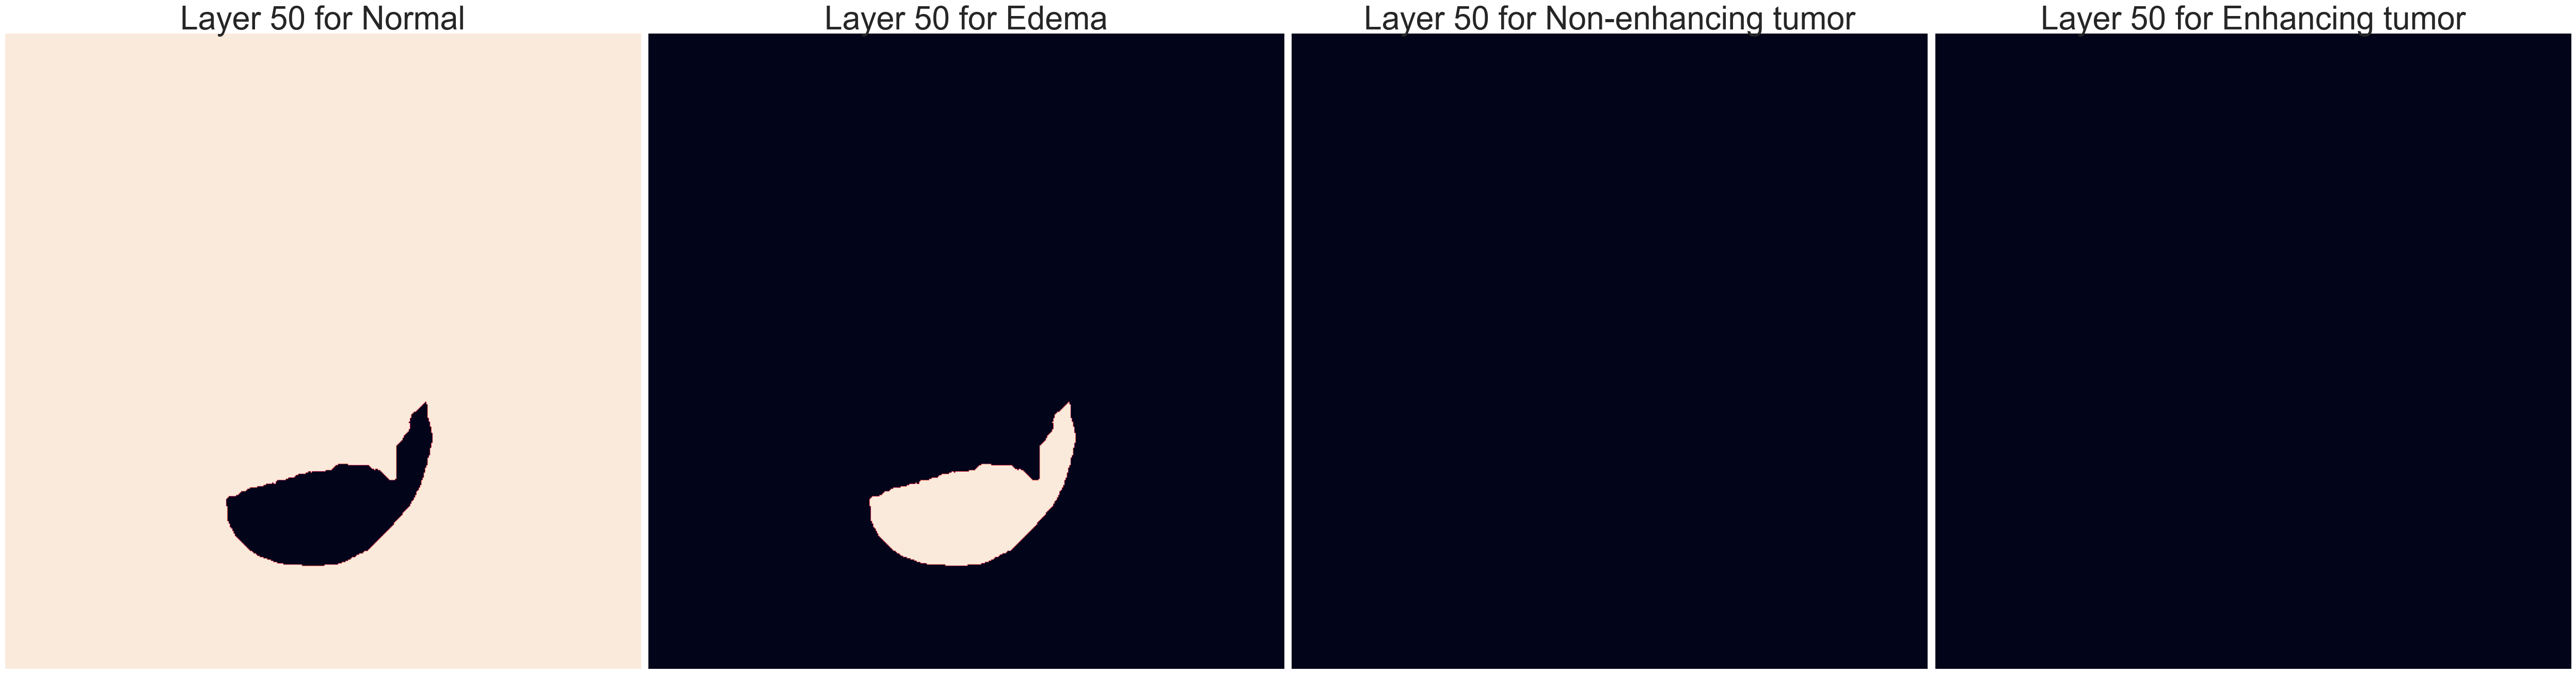

In [11]:
# Define a single layer for plotting
layer = 50
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3.
}
# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

In [21]:
# Interactive visualization across layers


In [12]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info',

)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)


# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)


interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

In [42]:
def writeSlices(series_tag_values, new_img, i, out_dir):
    image_slice = new_img[:,:,i]

    # castFilter = sitk.CastImageFilter()
    # castFilter.SetOutputPixelType(sitk.sitkInt16)
    # Convert floating type image (imgSmooth) to int type (imgFiltered)
    # imgFiltered = castFilter.Execute(image_slice)
    # sitk.WriteImage(imgFiltered, 'denoised.dcm')

    # print("image_slice ", image_slice)
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # Setting the type to CT preserves the slice location.
    image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    writer.SetImageIO("")
    writer.SetFileName(os.path.join(out_dir,'slice' + str(i).zfill(4) + '.dcm'))
    writer.Execute(image_slice)

In [85]:
def convert_nifti_to_dicom(in_dir, out_dir):

    # reader = sitk.ImageFileReader()
    # reader. SetImageIO("NiftiImageIO")
    # reader.SetFileName(in_dir)
    # new_img = reader.Execute()

    # option with nifti to dicom
    # image_obj = nib.load(image_path)
    # print("type image_obj ", type(image_obj))
    # new_img = image_obj.get_fdata()
    # new_img.SetSpacing([2.5, 3.5, 4.5])
    # new_img = sitk.Cast(new_img, sitk.sitkInt32)
    # print("type new_img ", type(new_img))
    #
    # new_img = sitk.GetImageFromArray(new_img)

    #correct
    new_img = sitk.ReadImage(in_dir, imageIO="NiftiImageIO")
    print("image.GetPixelIDValue() ", new_img.GetPixelIDValue())
    print("image.GetPixelIDTypeAsString() ", new_img.GetPixelIDTypeAsString())
    # print("new_img ", new_img)
    # new_img = sitk.Cast(new_img, sitk.sitkFloat32)
    new_img = sitk.Cast(new_img, sitk.sitkInt32)
    print("image.GetPixelIDValue() ", new_img.GetPixelIDValue())
    print("image.GetPixelIDTypeAsString() ", new_img.GetPixelIDTypeAsString())


    # castFilter = sitk.CastImageFilter()
    # castFilter.SetOutputPixelType(sitk.sitkInt16)
    # Convert floating type image (imgSmooth) to int type (imgFiltered)
    # new_img = castFilter.Execute(new_img)
    # print("new_img2 ", new_img)

    # image_obj = nib.load(image)
    # image = image_obj.get_fdata()

    # sitk.WriteImage(new_img, 'denoised.dcm')

    i = 0
    channel = 0
    print("type ", type(new_img))
    print(new_img)
    # print(f"Plotting Layer {i} Channel {channel} of Image")
    # plt.imshow(new_img, cmap='gray')
    # plt.axis('off');

    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    direction = new_img.GetDirection()
    print("direction type", type(direction))
    print("direction ", direction)
    series_tag_values = [("0008|0031",modification_time), # Series Time
                    ("0008|0021",modification_date), # Series Date
                    ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                    ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                    ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                        direction[1],direction[4],direction[7])))),
                    ("0008|103e", "Created-SimpleITK")] # Series Description

    # Write slices to output directory
    list(map(lambda i: writeSlices(series_tag_values, new_img, i, out_dir), range(new_img.GetDepth())))

In [86]:
in_path_nifti_dicom = r"E:\Task03_Liver\test_in"
out_path = r"E:\Task03_Liver\test_out"
if in_path_nifti_dicom:
        images = glob(in_path_nifti_dicom + '/*')
        print("images paths", images)
        if out_path:
            for i, image in enumerate(images):
                print('Converting...')
                print("image path", image)
                o_path = os.path.join(out_path, os.path.basename(image)[:-7])
                print("o_path ", o_path)
                if not os.path.exists(o_path): os.makedirs(o_path)

                # castFilter = sitk.CastImageFilter()
                # castFilter.SetOutputPixelType(sitk.sitkInt16)
                #
                # # Convert floating type image (imgSmooth) to int type (imgFiltered)
                # imgFiltered = castFilter.Execute(image)
                # sitk.WriteImage(imgFiltered, 'denoised.dcm')

                # new_arr = np.random.uniform(-10, 10, size = (3,4,5)).astype(np.int16)
                # new_img = sitk.GetImageFromArray(new_arr)
                # new_img.SetSpacing([2.5,3.5,4.5])
                #
                # out_path = os.path.join(out_path, "test_image")
                # writer = sitk.ImageFileWriter()
                # writer.KeepOriginalImageUIDOn()
                # writer.SetFileName(os.path.join(out_path,'slice' + 'test' + '.dcm'))
                # writer.Execute(new_img)
                #
                # print("new_img ", new_img)
                # print("out_path ", o_path)
                # image_obj = nib.load(image)
                # image = image_obj.get_fdata()
                convert_nifti_to_dicom(image, o_path)
                print('Files saved at\n' + out_path)

images paths ['E:\\Task03_Liver\\test_in\\liver_0.nii.gz', 'E:\\Task03_Liver\\test_in\\liver_1.nii.gz', 'E:\\Task03_Liver\\test_in\\liver_2.nii', 'E:\\Task03_Liver\\test_in\\liver_2.nii.gz', 'E:\\Task03_Liver\\test_in\\liver_4.nii.gz', 'E:\\Task03_Liver\\test_in\\liver_5.nii.gz']
Converting...
image path E:\Task03_Liver\test_in\liver_0.nii.gz
o_path  E:\Task03_Liver\test_out\liver_0
image.GetPixelIDValue()  8
image.GetPixelIDTypeAsString()  32-bit float
image.GetPixelIDValue()  4
image.GetPixelIDTypeAsString()  32-bit signed integer
type  <class 'SimpleITK.SimpleITK.Image'>
Image (000001FA792C62D0)
  RTTI typeinfo:   class itk::Image<int,3>
  Reference Count: 1
  Modified Time: 4614742
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 4614727
  UpdateMTime: 4614738
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 